### 1. Описание задачи

Некоторый частный банк среднего размера, который занимается всеми видами банковских продуктов, такими как сберегательные счета, текущие счета, инвестиционные продукты, кредитные продукты и другие предложения, также продаёт своим существующим клиентам свои продукты. Здесь банк хочет продать кредитные карты. Банк определил группу клиентов, которые имеют право на приобретение кредитных карт, и хочет определить, какие клиенты с наибольшей долей вероятности приобретут кредитную карту.

Приведём описание признаков клиентов:
* ID - идентификатор клиента
* Gender - пол
* Age - возраст
* Region code - код региона, где находится клиент
* Occupation - род деятельности
* Channel code - код канала приобретения клиента, т. е. какой вид связи наиболее удобен клиенту, чтобы предложить ему услуги банка (например, по телефону, через банковского приложение, по эл. почте и т.д.).
* Vintage - месяц, в котором был открыт счёт клиента. Анализ винтажа позволяет измерить эффективность портфеля в разные периоды времени после предоставления ссуды (или кредитной карты). Популярный метод управления кредитным риском.
* Credit product - имеет ли клиент какой-то из кредитных продуктов таких как ипотека, кредитная карта, потребительский кредит и т.д.
* Average account balance - средний остаток на счёте клиента за последние 12 месяцев
* Is active - был ли активен клиент в банке за последние три месяца
* Is lead - заинтересован ли клиент в приобретении кредитной карты (не означает, что банк готов предложить или выдать кредитную карту клиенту)

### 2. Прочитаем данные

In [278]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import sklearn

In [279]:
url = "https://raw.githubusercontent.com/paveladim/test-csv/main/train%20data%20credit%20card.csv"
data_raw = pd.read_csv(url)
url = "https://raw.githubusercontent.com/paveladim/test-csv/main/test%20data%20credit%20card.csv"
data_raw1 = pd.read_csv(url)

Поскольку датасет изначально разбит на тестовую и обучающую выборки, объединим их в одну таблицу.

In [280]:
data_raw.append(data_raw1)

data_raw['ID'] = data_raw['ID'].astype('category')
data_raw['Gender'] = data_raw['Gender'].astype('category')
data_raw['Region_Code'] = data_raw['Region_Code'].astype('category')
data_raw['Occupation'] = data_raw['Occupation'].astype('category')
data_raw['Channel_Code'] = data_raw['Channel_Code'].astype('category')
data_raw['Credit_Product'] = data_raw['Credit_Product'].astype('category')
data_raw['Is_Active'] = data_raw['Is_Active'].astype('category')

### 3. Визуализируем их и вычислим основные характеристики

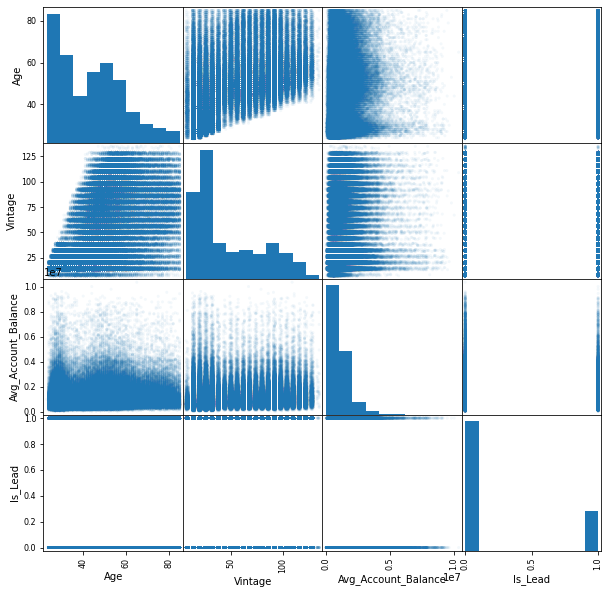

In [281]:
from pandas.plotting import scatter_matrix
scatter_matrix(data_raw, alpha = 0.05, figsize = (10, 10))
pass

Из графиков видно, что людей всех возрастов с достаточно высоким средним остатком на счёте достаточно мало по отношению ко всей группе клиентов. Подобное видно и в графике винтаж/средний остаток на счёте.

In [282]:
data_raw['Avg_Account_Balance'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     197786.16
0.010     233678.00
0.050     352992.80
0.100     432184.00
0.500     894601.00
0.900    2043591.00
0.950    2673533.00
0.990    4472872.60
0.995    5604702.42
Name: Avg_Account_Balance, dtype: float64

Видим, что у большинства клиентов банка средний остаток на счёте составляет от 197786.16 у.е. до 5604702.42 у.е.

In [283]:
rows_to_drop = data_raw[
    (data_raw['Avg_Account_Balance'] < data_raw['Avg_Account_Balance'].quantile(0.005)) 
    | (data_raw['Avg_Account_Balance'] > data_raw['Avg_Account_Balance'].quantile(0.995))].index

data = data_raw.drop(rows_to_drop)
data.shape


(243267, 11)

In [284]:
rows_to_drop.shape

(2458,)

In [285]:
data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,243267.000000,243267.000000,2.432670e+05,243267.000000
mean,43.868667,46.984223,1.104112e+06,0.237632
std,14.822166,32.346274,7.457303e+05,0.425633
min,23.000000,7.000000,1.977930e+05,0.000000
25%,30.000000,20.000000,6.068730e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,74.000000,1.359764e+06,0.000000
max,85.000000,135.000000,5.603502e+06,1.000000


In [286]:
data.describe(include=['category'])

,ID,Gender,Region_Code,Occupation,Channel_Code,Credit_Product,Is_Active
count,243267,243267,243267,243267,243267,214171,243267
unique,243267,2,35,4,4,2,2
top,222A8XWS,Male,RG268,Self_Employed,X1,No,No
freq,1,132895,35582,99981,102533,142766,148805


Построим матрицу корреляций

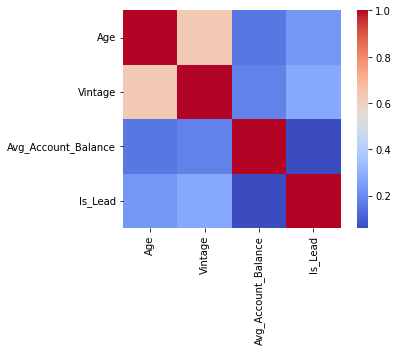

In [287]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### 4. Обработка пропущенных значений

In [288]:
data.isna().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29096
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

Видим, что у некоторой части клиентов неизвестно, пользуются ли они кредитными продуктами или нет.

In [289]:
data['Credit_Product'].fillna(data['Credit_Product'].mode().iloc[0], inplace=True)

In [290]:
data.isna().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

Пропущенные признаки обработаны. Они были заполнены модами.

### 5. Обработка категориальных признаков

Gender - бинарный признак, поэтому пусть 0 - female, 1 - male. Credit_Product и Is_Active бинарные тоже. Пусть 0 - No, 1- Yes.

In [291]:
data['Gender'] = pd.factorize(data['Gender'])[0]
data['Credit_Product'] = pd.factorize(data['Credit_Product'])[0]
data['Is_Active'] = pd.factorize(data['Is_Active'])[0]

Остальные признаки принимают несколько значений, поэтому обработаем их иначе.

In [292]:
Occupation_dummies = pd.get_dummies(data['Occupation'])
Channel_Code_dummies = pd.get_dummies(data['Channel_Code'])
Region_Code_dummies = pd.get_dummies(data['Region_Code'])

data = pd.concat((data, Occupation_dummies), axis=1)
data = data.drop(['Occupation'], axis=1)

data = pd.concat((data, Channel_Code_dummies), axis=1)
data = data.drop(['Channel_Code'], axis=1)

data = pd.concat((data, Region_Code_dummies), axis=1)
data = data.drop(['Region_Code'], axis=1)

# уберём ID, поскольку не нужно
data = data.drop(['ID'], axis = 1)

In [293]:
data

,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Entrepreneur,Other,Salaried,...,RG275,RG276,RG277,RG278,RG279,RG280,RG281,RG282,RG283,RG284
0,0,73,43,0,1045696,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30,32,0,581988,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,56,26,0,1484315,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,34,19,0,470454,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,30,33,0,886787,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245720,1,51,109,0,1925586,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
245721,1,27,15,0,862952,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
245722,0,26,13,0,670659,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
245723,0,28,31,0,407504,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### 6. Проведём нормализацию

Проведём стандартизацию всех признаков

In [294]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Entrepreneur,Other,Salaried,...,RG275,RG276,RG277,RG278,RG279,RG280,RG281,RG282,RG283,RG284
count,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,...,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05,2.432670e+05
mean,-5.970186e-17,1.105828e-16,-1.016451e-16,4.311152e-17,-1.446397e-16,-6.425837e-17,-4.213304e-17,5.140669e-18,3.306385e-17,-3.464110e-17,...,-3.972335e-18,7.886254e-18,-1.986168e-17,-4.412651e-17,-6.776337e-18,-2.178943e-17,1.477942e-17,-3.621835e-17,-1.168334e-17,-4.708386e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.097296e+00,-1.407936e+00,-1.236131e+00,-6.445750e-01,-1.215345e+00,-7.967442e-01,-5.583019e-01,-1.047840e-01,-6.321558e-01,-6.431762e-01,...,-1.157458e-01,-1.068299e-01,-2.347722e-01,-8.645962e-02,-1.279427e-01,-2.341868e-01,-1.458638e-01,-1.562967e-01,-3.688349e-01,-2.921791e-01
25%,-1.097296e+00,-9.356707e-01,-8.342297e-01,-6.445750e-01,-6.667819e-01,-7.967442e-01,-5.583019e-01,-1.047840e-01,-6.321558e-01,-6.431762e-01,...,-1.157458e-01,-1.068299e-01,-2.347722e-01,-8.645962e-02,-1.279427e-01,-2.341868e-01,-1.458638e-01,-1.562967e-01,-3.688349e-01,-2.921791e-01
50%,9.113270e-01,-5.860594e-02,-4.632442e-01,-6.445750e-01,-2.809480e-01,-7.967442e-01,-5.583019e-01,-1.047840e-01,-6.321558e-01,-6.431762e-01,...,-1.157458e-01,-1.068299e-01,-2.347722e-01,-8.645962e-02,-1.279427e-01,-2.341868e-01,-1.458638e-01,-1.562967e-01,-3.688349e-01,-2.921791e-01
75%,9.113270e-01,6.835258e-01,8.352052e-01,1.551403e+00,3.428198e-01,1.255103e+00,-5.583019e-01,-1.047840e-01,1.581882e+00,1.554778e+00,...,-1.157458e-01,-1.068299e-01,-2.347722e-01,-8.645962e-02,-1.279427e-01,-2.341868e-01,-1.458638e-01,-1.562967e-01,-3.688349e-01,-2.921791e-01
max,9.113270e-01,2.774988e+00,2.721048e+00,1.551403e+00,6.033535e+00,1.255103e+00,1.791138e+00,9.543399e+00,1.581882e+00,1.554778e+00,...,8.639584e+00,9.360636e+00,4.259431e+00,1.156605e+01,7.815967e+00,4.270077e+00,6.855684e+00,6.398061e+00,2.711229e+00,3.422545e+00


### 7. Разобьём данные на обучающую и тестовую выборки

In [296]:
X = data_stand
y = data['Is_Lead']

In [297]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 66)

### 8. Запустим KNN

In [315]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=7, p=1)

model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, p=1)

### 9. Вычислим ошибки на обучающей и тестовой выборках